In [1]:
# ===============================
# 1. IMPORT LIB
# ===============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set(style="whitegrid")

In [2]:
# ===============================
# 2. CONNECT & LOAD DATA
# ===============================
print("🔄 Connecting to MongoDB...")
client = MongoClient("mongodb://localhost:27017/")

db = client["goodread_file"]
books_col = db["goodread"]

print("📥 Fetching data...")
cursor = books_col.find()

data = []
for book in cursor:
    data.append({
        "title": book.get("title"),
        "author": book.get("author"),
        "publish_year": book.get("publish_year"),
        "avg_rating": book.get("avg_rating"),
        "review_count": book.get("review_count"),
        "book_url": book.get("book_url"),
        "cover_image": book.get("cover_image")
    })

df = pd.DataFrame(data)

print("📌 Columns:", df.columns.tolist())
print(f"✅ Total books loaded: {len(df)}")
print("-" * 50)

🔄 Connecting to MongoDB...
📥 Fetching data...
📌 Columns: ['title', 'author', 'publish_year', 'avg_rating', 'review_count', 'book_url', 'cover_image']
✅ Total books loaded: 1274
--------------------------------------------------


In [3]:
# ===============================
# 3. DATA CLEANING
# ===============================
df['avg_rating'] = pd.to_numeric(df['avg_rating'], errors='coerce').fillna(0)
df['review_count'] = pd.to_numeric(df['review_count'], errors='coerce').fillna(0)
df['publish_year'] = pd.to_numeric(df['publish_year'], errors='coerce')


In [4]:
# ===============================
# 4. DATA QUERIES & ANALYSIS
# ===============================

# Q1: Tổng số sách
print(f"Q1: Tổng số sách: {len(df)}")


Q1: Tổng số sách: 1274


In [5]:
# Q2: Top 10 sách rating cao nhất
print("\nQ2: Top 10 sách rating cao nhất")
top_rating = df.sort_values(by='avg_rating', ascending=False).head(10)
print(top_rating[['title', 'author', 'avg_rating', 'review_count']])



Q2: Top 10 sách rating cao nhất
                                    title             author  avg_rating  review_count
784                          Know My Name      Chanel Miller        4.68        254773
510                      The Way of Kings  Brandon Sanderson        4.66        658811
564                       The Nightingale     Kristin Hannah        4.65       2047984
495              A Court of Mist and Fury      Sarah J. Maas        4.64       3129501
486  Harry Potter and the Deathly Hallows       J.K. Rowling        4.62       4082826
872                            Just Mercy    Bryan Stevenson        4.62        259987
569                             The Women     Kristin Hannah        4.59       1503810
338  The Sandman, Vol. 9: The Kindly Ones        Neil Gaiman        4.58         52458
307                     The Complete Maus     Art Spiegelman        4.58        252078
547             Heartstopper: Volume Four       Alice Oseman        4.58        438570



Q3: Correlation giữa review_count và avg_rating: 0.0979


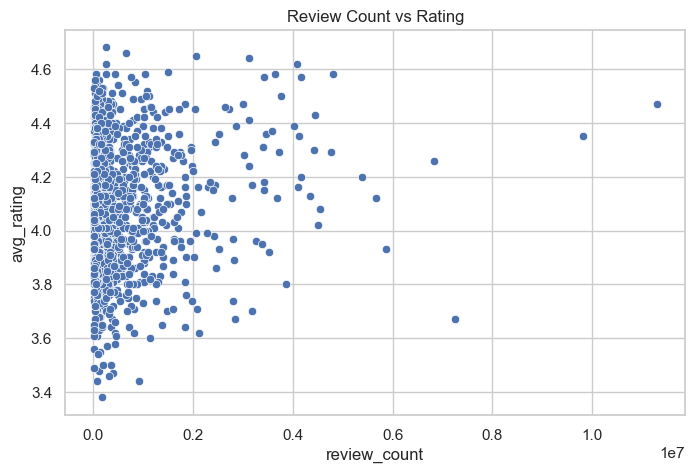

In [6]:
# Q3: Tương quan rating và review
corr = df['review_count'].corr(df['avg_rating'])
print(f"\nQ3: Correlation giữa review_count và avg_rating: {corr:.4f}")

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='review_count', y='avg_rating')
plt.title("Review Count vs Rating")
plt.show()

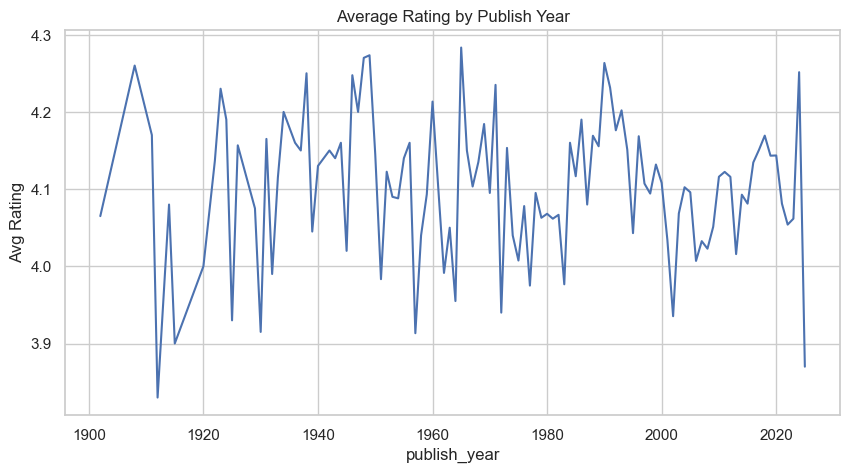

In [7]:
# Q4: Rating trung bình theo năm phát hành
df_year = df[(df['publish_year'] >= 1900) & (df['publish_year'] <= 2025)]
year_avg = df_year.groupby('publish_year')['avg_rating'].mean()

plt.figure(figsize=(10,5))
year_avg.plot()
plt.title("Average Rating by Publish Year")
plt.ylabel("Avg Rating")
plt.show()


In [8]:
# Q5: Underrated books (rating cao, ít review)
print("\nQ5: Underrated books")
underrated = df[(df['avg_rating'] >= 4.5) & (df['review_count'] < 1000)]
print(underrated[['title', 'avg_rating', 'review_count']].head(10))


Q5: Underrated books
Empty DataFrame
Columns: [title, avg_rating, review_count]
Index: []


In [9]:
# Q6: Overhyped books (nhiều review, rating thấp)
threshold = df['review_count'].quantile(0.8)
overhyped = df[(df['avg_rating'] < 3.5) & (df['review_count'] > threshold)]
print("\nQ6: Overhyped books")
print(overhyped[['title', 'avg_rating', 'review_count']].head(10))


Q6: Overhyped books
                  title  avg_rating  review_count
272  The Scarlet Letter        3.44        914451



Q7: Cluster centers (scaled)
[[-0.81892041 -0.18461248]
 [ 0.79022677 -0.17007548]
 [ 0.45675651  3.52807769]]


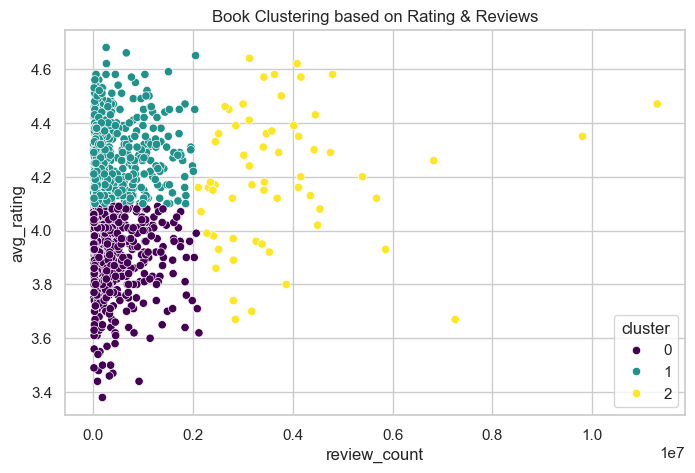


🎉 DONE – CODE CHẠY HOÀN TOÀN THÀNH CÔNG


In [10]:
# ===============================
# 5. CLUSTERING (ML)
# ===============================
features = df[['avg_rating', 'review_count']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(features_scaled)

print("\nQ7: Cluster centers (scaled)")
print(kmeans.cluster_centers_)

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df,
    x='review_count',
    y='avg_rating',
    hue='cluster',
    palette='viridis'
)
plt.title("Book Clustering based on Rating & Reviews")
plt.show()

print("\n🎉 DONE – CODE CHẠY HOÀN TOÀN THÀNH CÔNG")
